# setup

In [1]:
import os

if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('..')

In [2]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
import tensorflow_probability as tfp
# import tensorflow_addons as tfa
import pandas as pd
import sys
import sklearn.model_selection

from random import randint
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import figure
from IPython.display import SVG
from sklearn.linear_model import LinearRegression

2024-08-12 18:02:41.361869: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [4]:
from tensorflow.python.keras import layers, initializers, optimizers
from tensorflow.python.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv2D
from tensorflow.python.keras.layers import AveragePooling1D, MaxPooling2D, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.python.keras.layers import LeakyReLU, Reshape
from tensorflow.python.keras.models import Model, model_from_json, load_model
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras.applications.imagenet_utils import preprocess_input
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.backend import manual_variable_initialization
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow.python.keras.backend as K
K.set_image_data_format('channels_last')

# utils

In [5]:
def ricker_wav(f, n, dt, t0):
    T = dt * (np.floor(n / 2))
    t = np.linspace(-T, T, n)
    tau = t - t0
    pi = np.pi
    s = (1-2*tau*tau*f**2*pi**2) * np.exp(-tau**2*pi**2*f**2)
    rw = s
    return rw, t

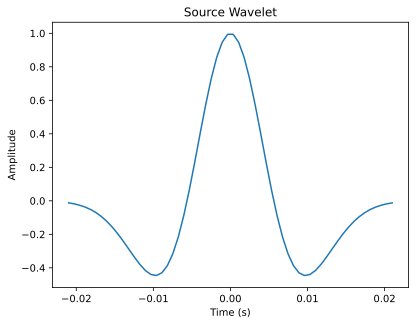

In [6]:
freq = 40
src_len = 60
dt = 7e-4
wvlt, tt = ricker_wav(freq, src_len, dt, 0)

plt.plot(tt, wvlt);
plt.xlabel("Time (s)");
plt.ylabel("Amplitude");
plt.title("Source Wavelet");

In [7]:
def SoftSandNew(Kf, RHOf, Phi, Quartz, Clay, Feldspar, Limestone, Dolomite, Pressure, PhiC, Coordination, Fudge):
    # Uncemented sand rock physics model (modified to implement automatic-differentiation)
    #               INPUTS
    #
    #Kf				Fluid bulk modulus
    #RHOB			Fluid density
    #Phi			Porosity (fraction)
    #Quartz, etc.	Volume mineral content in solid phase (fraction)
    #Pressure		Effective pressure (MPa)
    #PhiC			Critical porosity ~0.4
    #Coordination	Coordination number ~6
    #Fudge			Reduction in shear stiffness -- 1 by default
    #
    #a is the contact radius between two spheres at input pressure

    #Balancing mineralogy
    Dolomite = 1 - (Quartz + Clay + Feldspar + Limestone)
    
    #Constants for clay
    KClay = 21
    GClay = 7
    RHOClay = 2.65

    #Solid-phase elastic moduli
    KsV = Quartz*36.6 + Clay*KClay + Feldspar*75.6 + Limestone*76.8 + Dolomite*94.9
    KsR = 1 / (Quartz/36.6 + Clay/KClay + Feldspar/75.6 + Limestone/76.8 + Dolomite/94.9)
    Ks = 0.5 * (KsV + KsR)
    
    GsV = Quartz*45 + Clay*GClay + Feldspar*25.6 + Limestone*32 + Dolomite*45
    GsR = 1 / (Quartz/45 + Clay/GClay + Feldspar/25.6 + Limestone/32 + Dolomite/45)
    Gs = 0.5 * (GsV + GsR)

    Ms = Ks + (4/3)*Gs
    NUs = 0.5 * (Ms/Gs-2) / (Ms/Gs-1)
    
    #Solid-phase density
    RHOs = Quartz*2.65 + Clay*RHOClay + Feldspar*2.63 + Limestone*2.71 + Dolomite*2.87
    
    #ILLITE
    #RHOs=2.58; Ms=RHOs.*4.32.*4.32; Gs=RHOs.*2.54.*2.54; NUs=0.5*(Ms./Gs-2)./(Ms./Gs-1); Ks=Ms-(4/3)*Gs;
    
    P = Pressure / 1000
    C = Coordination
    
    #================== Dry Rock ====================
    #Effective K and G at PhiC
    #Hertz contact radius (R=1)
    a = tf.pow(((3*3.14*(1-NUs) / (2*C*(1-PhiC)*Gs))*P), (1/3))
    #Normal contact stiffness
    SN = 4*a*Gs / (1-NUs)
    #Shear contact stiffness
    ST = 8*a*Gs / (2-NUs)
    #Shear contact stiffness FUDGED (reduced)
    ST = ST / Fudge
    
    #Bulk modulus
    Khat = C*(1.-PhiC)*SN / (12*3.14)
    #Shear modulus
    Ghat = C*(1.-PhiC)*(SN+1.5*ST) / (20*3.14)
    
    #Effective bulk and shear moduli at porosity Phi<=PhiC
    KDry1 = 1/((Phi/PhiC)/(Khat+4*Ghat/3)+((PhiC-Phi)/PhiC)/(Ks+4*Ghat/3))-4*Ghat/3
    ZZ1 = (Ghat/6)*(9*Khat+8*Ghat)/(Khat+2*Ghat)
    GDry1 = 1/((Phi/PhiC)/(Ghat+ZZ1)+((PhiC-Phi)/PhiC)/(Gs+ZZ1))-ZZ1
    MDry1 = KDry1+(4/3)*GDry1
    NuDry1 = 0.5*(MDry1/GDry1-2)/(MDry1/GDry1-1)
    
    #Effective bulk and shear moduli at porosity Phi>PhiC
    KDry2 = 1/(((1-Phi)/(1-PhiC))/(Khat+4*Ghat/3)+((Phi-PhiC)/(1-PhiC))/(4*Ghat/3))-4*Ghat/3
    ZZ2 = (Ghat/6)*(9*Khat+8*Ghat)/(Khat+2*Ghat)
    GDry2 = 1/(((1-Phi)/(1-PhiC))/(Ghat+ZZ2)+((Phi-PhiC)/(1-PhiC))/(ZZ2))-ZZ2
    MDry2 = KDry2+(4/3)*GDry2
    NuDry2 = 0.5*(MDry2/GDry2-2)/(MDry2/GDry2-1)
    
    MDry = MDry1*(tf.cast((Phi<=PhiC), tf.float64))+MDry2*(tf.cast((Phi>PhiC), tf.float64)) 
    GDry = GDry1*(tf.cast((Phi<=PhiC), tf.float64))+GDry2*(tf.cast((Phi>PhiC), tf.float64))
    NuDry = NuDry1*(tf.cast((Phi<=PhiC), tf.float64))+NuDry2*(tf.cast((Phi>PhiC), tf.float64))
    KDry = MDry-(4/3)*GDry
    
    # ================== Saturated Rock ============
    KSat = Ks*(Phi*KDry-(1+Phi)*Kf*KDry/Ks+Kf)/((1-Phi)*Kf+Phi*Ks-Kf*KDry/Ks)
    MSat = KSat+(4/3)*GDry
    RHOB = (1-Phi)*RHOs+Phi*RHOf
    Vp = tf.pow((MSat/RHOB),0.5)
    Vs = tf.pow((GDry/RHOB),0.5)
    Ip = Vp*RHOB
    PR = 0.5*(MSat/GDry-2)/(MSat/GDry-1)
    
    return Vp, Vs, RHOB

In [8]:
def RC_fwd_model(vp1, d1, vp2, d2):
    Rpp = (vp2*d2-vp1*d1) / (vp2*d2+vp1*d1)
    return Rpp

In [9]:
def RC_fwd_model_ia(ia1, ia2):
    Rpp = (ia2-ia1) / (ia2+ia1)
    return Rpp

# read

In [10]:
Kg = 0.06
Kw = 2.61
RHOw = 1.01
RHOg = 0.18 
diffP = 16.5 
RHOs = 2.65
PhiC = 0.4 
Coordination = 14 
Fudge = 1
diffDepth = 1

# We have not analyzed the impact of partialsaturations or the presence of clay on the predictions
vclay = tf.cast(0, tf.float64)
sw = tf.cast(1, tf.float64)

2024-08-12 18:02:43.289126: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-08-12 18:02:43.289833: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-08-12 18:02:43.928525: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 18:02:43.928901: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.78GiB deviceMemoryBandwidth: 607.97GiB/s
2024-08-12 18:02:43.928919: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-08-12 18:02:43.932176: I tensorflow/stream_executor/platform/default/dso_loade

In [11]:
seis = np.load('seismic_data.npy') ##seismic data
phi_true = np.load('porosity_data.npy') ##porosity data
seis.shape, phi_true.shape

((2500, 246), (2500, 199))

In [12]:
phi_max = np.max(phi_true) #can also take 1 or critical porosity (0.4)
phi_min = np.min(phi_true) #can also take 0
phi_max, phi_min

(0.4, 0.11)

In [13]:
# Normalizing the input and output data  

seis_normalized = (seis - np.min(seis)) / (np.max(seis) - np.min(seis))

#seis_compiled=np.concatenate((seis_normalized[:,0,:],seis_normalized[:,1,:]),axis=1)
seis_compiled = seis_normalized

true_output = np.zeros((seis_normalized.shape[0],199))
true_output[:,0:199] = (phi_true-phi_min) / (phi_max-phi_min)

seis_plus_petro_compiled = np.concatenate((seis_compiled, true_output), axis=1)

X_train, X_test, Y_train_unmasked, Y_test_unmasked = sklearn.model_selection.train_test_split(seis_normalized, seis_plus_petro_compiled, test_size = 0.2, random_state = 1)

X_train_final = np.expand_dims(np.expand_dims(X_train, axis=1), axis=3)
X_test_final = np.expand_dims(np.expand_dims(X_test, axis=1), axis=3)
mask_output_test = Y_test_unmasked[:,0:1] - Y_test_unmasked[:,0:1]
Y_test = np.concatenate((Y_test_unmasked,mask_output_test), axis=1)
mask_output_train = Y_train_unmasked[:,0:1] - Y_train_unmasked[:,0:1]
mask_no = 4 ##number of prior known porosity logs
mask_output_train[0:mask_no, :] = 1
Y_train = np.concatenate((Y_train_unmasked,mask_output_train), axis=1)

print ("number of training examples = " + str(X_train_final.shape[0]))
print ("number of test examples = " + str(X_test_final.shape[0]))
print ("X_train shape: " + str(X_train_final.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test_final.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 2000
number of test examples = 500
X_train shape: (2000, 1, 246, 1)
Y_train shape: (2000, 446)
X_test shape: (500, 1, 246, 1)
Y_test shape: (500, 446)


In [14]:
## Denominators for normalizing the RMS error in the loss function
denom_phi = tf.reduce_sum(tf.where(Y_train[:,-1]==1, tf.reduce_mean(Y_train[:,246:246+199],axis=1), Y_train[:,-1]))/mask_no
np.save('output/denom_phi.npy', denom_phi)

denom_seis = tf.reduce_mean(X_train)
np.save('output/denom_seis.npy', denom_seis)
denom_phi, denom_seis

(<tf.Tensor: shape=(), dtype=float64, numpy=0.3626062597470109>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.5142038419702656>)

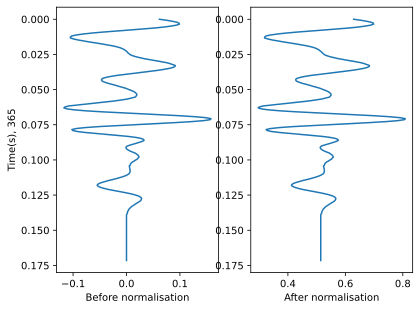

In [15]:
end_time = 0.172
time_upscaled = np.arange(0, end_time, dt)
i = np.random.choice(seis.shape[0], size = 1)[0]

plt.subplot(1,2,1);
plt.plot(np.squeeze(seis[i,:]), time_upscaled);
plt.gca().invert_yaxis();
plt.ylabel('Time(s), {}'.format(i));
plt.xlabel('Before normalisation');

plt.subplot(1,2,2);
plt.plot(np.squeeze(seis_normalized[i,:]), time_upscaled);
plt.gca().invert_yaxis();
plt.xlabel('After normalisation');

# regressao

In [16]:
porosidade = Y_train[0:mask_no, 246:-1]
vepe, vese, rho = SoftSandNew(2.61, 1.01, porosidade, (1 - vclay)*0.8, vclay, (1 - vclay)*0.2, 0, 0, diffP, PhiC, Coordination, Fudge)
impedancia = (vepe * rho).numpy()

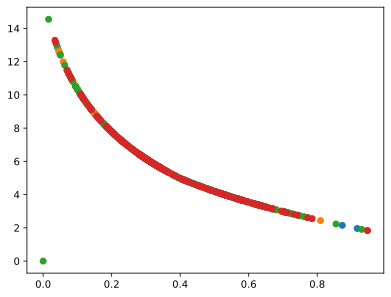

In [17]:
impedancia[np.isnan(impedancia)] = 0
for i in range(mask_no):
    plt.scatter(porosidade[i, :], impedancia[i, :]);

(array([[-11.39919887]]), array([10.10783853]))

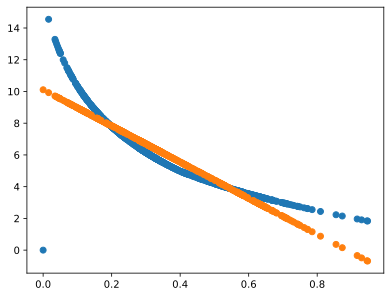

In [18]:
regr_lr = LinearRegression().fit(porosidade.reshape(-1, 1), impedancia.reshape(-1, 1))

for i in range(mask_no):
    plt.scatter(porosidade[i, :], impedancia[i, :], color = 'tab:blue');
    plt.scatter(porosidade[i, :], porosidade[i, :] * regr_lr.coef_+ regr_lr.intercept_, color = 'tab:orange');
regr_lr.coef_, regr_lr.intercept_

333

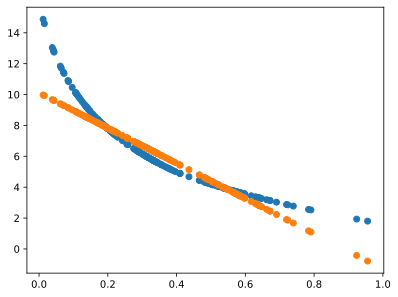

In [19]:
i = np.random.choice(X_train_final.shape[0], size = 1)[0]
porosidade = Y_train[i:i+1, 246:-1]
vepe, vese, rho = SoftSandNew(2.61, 1.01, porosidade, (1 - vclay)*0.8, vclay, (1 - vclay)*0.2, 0, 0, diffP, PhiC, Coordination, Fudge)
impedancia = (vepe * rho).numpy()

plt.scatter(porosidade[0, :], impedancia[0, :]);
plt.scatter(porosidade[0, :], porosidade[0, :] * regr_lr.coef_+ regr_lr.intercept_);
i

In [20]:
# beta1 = tf.Variable(initial_value = regr_lr.coef_, dtype = tf.float32, trainable = True)
# beta0 = tf.Variable(initial_value = regr_lr.intercept_, dtype = tf.float32, trainable = True)

In [21]:
# from tensorflow.python.keras.layers import Lambda
from tensorflow.python.keras.layers import Layer

class Linear1D(Layer):
    def __init__(self):
        super().__init__()
        self.beta1 = self.add_weight(shape = (1, 1), initializer = initializers.Constant(regr_lr.coef_[0]), trainable = True, name = 'beta1')
        self.beta0 = self.add_weight(shape = (1), initializer = initializers.Constant(regr_lr.intercept_[0]), trainable = True, name = 'beta0')
        # self.beta1 = self.add_weight(shape = (1, 1), initializer = 'random_normal', trainable = True, name = 'beta1')
        # self.beta0 = self.add_weight(shape = (1, 1), initializer = 'random_normal', trainable = True, name = 'beta0')
        # self.beta1 = self.add_weight(shape = (1, 1), initializer = initializers.Constant(-10), trainable = True, name = 'beta1')
        # self.beta0 = self.add_weight(shape = (1, 1), initializer = initializers.Constant(10), trainable = True, name = 'beta0')
    
    def call(self, inputs):
        # return inputs * self.beta1 + self.beta0
        return tf.math.multiply(inputs, self.beta1) + self.beta0
        # return tf.math.multiply(inputs, self.beta1 * 10) + self.beta0 * 10

# model

In [22]:
def DecoderLinearInterpLayer(x, xp, fp):
    i = tf.clip_by_value(tf.searchsorted(xp, x, side='right'), 1, xp.shape[1] - 1)

    fp1 = tf.gather(fp, indices=i-1, batch_dims=1)
    fp2 = tf.gather(fp, indices=i, batch_dims=1)
    xp1 = tf.gather(xp, indices=i-1, batch_dims=1)
    xp2 = tf.gather(xp, indices=i, batch_dims=1)

    f = (fp1 *  (xp2 - x) + fp2 * (x - xp1)) / (xp2 - xp1)

    left = fp[0,0]
    right = fp[-1,-1]

    ff = tf.where(x < tf.ones_like(x)*tf.expand_dims(xp[:,0],axis=1), left, f)
    fff = tf.where(x > tf.ones_like(x)*tf.expand_dims(xp[:,-1],axis=1), tf.ones_like(x)*tf.expand_dims(fp[:,-1],axis=1), ff)
    return fff

In [23]:
given_seed = 2

input_final = Input(shape=(X_train_final.shape[1:]))

# Encoder
#1
X = Conv2D(32, (1, 3), strides=(1, 2), name='conv0', padding='same',
           kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros')(input_final)

#X = BatchNormalization(axis=-1, name='bn0')(X)
X = Activation('relu')(X)
#X = Dropout(rate=0.3, name='drop_conv0')(X)

#2
X = Conv2D(64, (1, 7), strides=(1, 2), name='conv1',padding='same',
           kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros')(X)

#X = BatchNormalization(axis=-1, name='bn1')(X)
X = Activation('relu')(X)
#X = Dropout(rate=0.3, name='drop_conv1')(X)

#3
X = Conv2D(128, (1, 15), strides=(1, 2), name='conv2',padding='same',
           kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros')(X)

#X = BatchNormalization(axis=-1, name='bn2')(X)
X = Activation('relu')(X)
#X = Dropout(rate=0.3, name='drop_conv2')(X)

#4 
X = Conv2D(256, (1, 30), strides=(1, 2), name='conv3',padding='same',
           kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros')(X)
          
#X = BatchNormalization(axis=-1, name='bn3')(X)
X = Activation('relu')(X)
X = Dropout(rate=0.3, name='drop_conv3')(X)

# FLATTEN X + FULLYCONNECTED
X = Flatten()(X)
    
X = Dense(199, name='fc0',
          kernel_initializer=initializers.he_uniform(seed=given_seed), bias_initializer='zeros')(X)

encoded = Activation('tanh')(X) ##to scale the output between –1 and 1 before passing it as input to the decoder

# Decoder
encoded = tf.cast(encoded, tf.float64)

phi_for = ((encoded + 1) / 2) ##scaled between 0 and 1

phi = phi_for * (phi_max - phi_min) + phi_min + 1e-07

depth = np.arange(1, phi.shape[1]+1) * diffDepth

RHOf = sw*RHOw + (1 - sw) * RHOg
Kf = 1/(sw/Kw + (1 - sw)/Kg)

Vp_final, Vs_final, RHO_final = SoftSandNew(Kf, RHOf, phi, (1 - vclay)*0.8, vclay, (1 - vclay)*0.2, 0, 0, diffP, PhiC, Coordination, Fudge)
# impedance_final = Vp_final * RHO_final

# impedance_final = phi * regr_lr.coef_ + regr_lr.intercept_
# impedance_final = phi * beta1 + beta0
impedance_final = Linear1D()(phi)

impedance_final = tf.cast(impedance_final, tf.float64)

#Seismic part

depth_diff = np.mean(np.diff(depth.T))
time0 = 0.0/(Vp_final[:,0])
# time0 = 0.0/(impedance_final[:,0])
time1 = 2*tf.cumsum(depth_diff/(Vp_final*1e3),axis=1)
# time1 = 2*tf.cumsum(depth_diff/(impedance_final*1e3),axis=1)
time_final = tf.concat([tf.expand_dims(time0, axis=1),time1],axis=1)
time = time_final[:,0:-1]

time_new = tf.ones_like(time, dtype=tf.float64)
for i in range(len(time_upscaled) - time.shape[1]):
    time_new = tf.concat([time_new,tf.expand_dims(time0+1.0,axis=1)],axis=1)
pred_t = time_new*time_upscaled

# Vp_time = DecoderLinearInterpLayer(pred_t, time, Vp_final)
# RHO_time = DecoderLinearInterpLayer(pred_t, time, RHO_final)
impedance_time = DecoderLinearInterpLayer(pred_t, time, impedance_final)

# Rpp_0 = RC_fwd_model(Vp_time[:,0:-1], RHO_time[:,0:-1], Vp_time[:,1:], RHO_time[:,1:])
Rpp_0 = RC_fwd_model_ia(impedance_time[:,0:-1], impedance_time[:,1:])
# Rpplast = 0.0 / (Vp_time[:,0])
Rpplast = 0.0 / (impedance_time[:,0])
Rpp0 = tf.concat([Rpp_0, tf.expand_dims(Rpplast, axis=1)], axis=1)

kernel_wvlt = tf.reshape(wvlt, [int(wvlt.shape[0]), 1, 1])
RC0 = tf.expand_dims(Rpp0, axis=2)
seis_for0 = tf.squeeze(tf.nn.conv1d(RC0, tf.reverse(kernel_wvlt,[0]), 1,'SAME'),axis=2)
    
seis_for_normalized = (seis_for0 - np.min(seis))/(np.max(seis)-np.min(seis))

seis_for_final = tf.concat([seis_for_normalized, phi_for],axis=1)

x (sismica) -> CNN -> phi (porosidade) \
phi . beta + cte = impendance (vp * rho) \
compute_reflectivity_coefficients(impendace) -> Rpp (refletividade) \
rpp conv wavelet -> x (sismica)

In [24]:
rw_pinn = Model(inputs = input_final, outputs = seis_for_final)
rw_pinn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 246, 1)]  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 1, 123, 32)   128         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 1, 123, 32)   0           conv0[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 1, 62, 64)    14400       activation[0][0]                 
______________________________________________________________________________________________

# train

In [25]:
class loss_func(tf.keras.losses.Loss):
    def __init__(self):
        super().__init__()
    def call(self, y_true, y_pred):
        mse_seis1 = tf.reduce_mean(tf.square(y_pred[:,0:246] - y_true[:,0:246]))
        
        return tf.math.sqrt(mse_seis1)

In [26]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
rw_pinn.compile(loss = loss_func(), optimizer = adam)

In [27]:
# Using early stopping and Model Checkpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint('output/rwpinn_model.h5', monitor='val_loss', mode='min', verbose=1, save_weights_only=True)

In [28]:
# Start the training

Batch_size = 128
history = rw_pinn.fit(X_train_final, Y_train, 
                      validation_split=0.2, epochs=200, 
                      batch_size=Batch_size, callbacks=[es, mc], verbose = 1)

2024-08-12 18:02:46.960419: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-08-12 18:02:46.979368: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2799925000 Hz


Epoch 1/200


2024-08-12 18:02:49.406941: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-08-12 18:02:49.768800: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2024-08-12 18:02:49.775318: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


13/13 [==============================] - 5s 67ms/step - loss: 0.1277 - val_loss: 0.0968

Epoch 00001: saving model to output/rwpinn_model.h5
Epoch 2/200
13/13 [==============================] - 0s 10ms/step - loss: 0.0948 - val_loss: 0.0645

Epoch 00002: saving model to output/rwpinn_model.h5
Epoch 3/200
13/13 [==============================] - 0s 10ms/step - loss: 0.0673 - val_loss: 0.0500

Epoch 00003: saving model to output/rwpinn_model.h5
Epoch 4/200
13/13 [==============================] - 0s 10ms/step - loss: 0.0542 - val_loss: 0.0419

Epoch 00004: saving model to output/rwpinn_model.h5
Epoch 5/200
13/13 [==============================] - 0s 10ms/step - loss: 0.0466 - val_loss: 0.0365

Epoch 00005: saving model to output/rwpinn_model.h5
Epoch 6/200
13/13 [==============================] - 0s 10ms/step - loss: 0.0417 - val_loss: 0.0326

Epoch 00006: saving model to output/rwpinn_model.h5
Epoch 7/200
13/13 [==============================] - 0s 10ms/step - loss: 0.0381 - val_loss: 0

In [29]:
regr_lr.coef_, regr_lr.intercept_

(array([[-11.39919887]]), array([10.10783853]))

In [30]:
rw_pinn.get_layer('linear1d').get_weights()

[array([[-11.478432]], dtype=float32), array([10.028436], dtype=float32)]

# eval

In [31]:
# load the saved model
rw_pinn.load_weights('output/rwpinn_model.h5')

In [32]:
# Testing and evaluating the model
Batch_size = 128
preds = rw_pinn.evaluate(X_test_final, Y_test, batch_size=Batch_size, verbose=0, sample_weight=None)
print("Loss = " + str(preds))

Loss = 0.008357379585504532


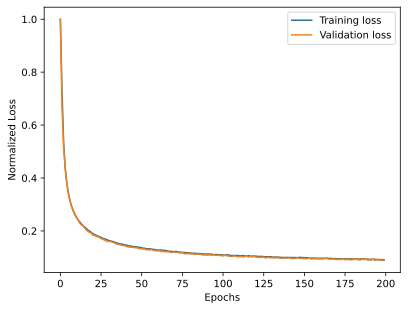

In [33]:
# Plotting the learning curve 
plt.plot(history.history['loss']/np.max(history.history['loss']));
plt.plot(history.history['val_loss']/np.max(history.history['val_loss']));

#plt.title('Learning curve')
plt.ylabel('Normalized Loss');
plt.xlabel('Epochs');
plt.legend(['Training loss', 'Validation loss'], loc='upper right');

# plt.ylim([0.05, 0.2]);

## encoder

In [34]:
## Only the Encoder part
rw_pinn_encoder = Model(inputs=input_final, outputs=encoded)

In [35]:
encoder_output_trainset = rw_pinn_encoder.predict(X_train_final)
phi_trainset_pred = ((encoder_output_trainset+1)/2) * (phi_max - phi_min) + phi_min 

In [36]:
encoder_output_testset = rw_pinn_encoder.predict(X_test_final)
phi_testset_pred = ((encoder_output_testset+1)/2) * (phi_max - phi_min) + phi_min

In [37]:
phi_trainset_true = Y_train[:, 246:246+199] * (phi_max - phi_min) + phi_min
phi_testset_true = Y_test[:, 246:246+199] * (phi_max - phi_min) + phi_min

In [38]:
phi_train_error = mean_squared_error(phi_trainset_true,phi_trainset_pred)
phi_test_error = mean_squared_error(phi_testset_true,phi_testset_pred)

print('Porosity Train error:',phi_train_error)
print('Porosity Test error:',phi_test_error)

Porosity Train error: 0.005354063888130209
Porosity Test error: 0.00535241410531911


103

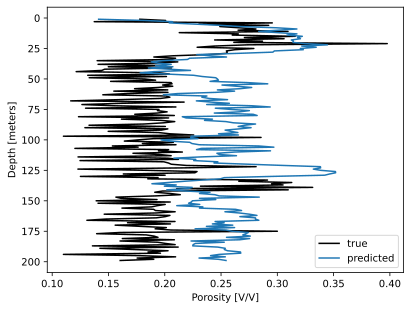

In [39]:
# sample_number = 400
sample_number = np.random.choice(phi_trainset_true.shape[0], size = 1)[0]

plt.plot(phi_trainset_true[sample_number, :], depth, color = "black", label = 'true');
plt.plot(phi_trainset_pred[sample_number, :], depth, label = 'predicted');
plt.xlabel("Porosity [V/V]");
plt.ylabel("Depth [meters]");
plt.legend();
plt.gca().invert_yaxis();
sample_number

462

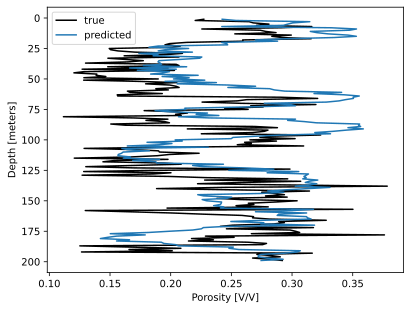

In [40]:
# sample_number = 400
sample_number = np.random.choice(phi_testset_true.shape[0], size = 1)[0]

plt.plot(phi_testset_true[sample_number, :], depth, color = "black", label = 'true');
plt.plot(phi_testset_pred[sample_number, :], depth, label = 'predicted');
plt.xlabel("Porosity [V/V]");
plt.ylabel("Depth [meters]");
plt.legend();
plt.gca().invert_yaxis();
sample_number

## decoder

In [41]:
## Only the Decoder part
# rw_pinn_decoder = Model(inputs=encoded, outputs=seis_for_final)

In [42]:
# decoder_output_trainset = rw_pinn_decoder.predict(encoder_output_trainset)
# seis_output_trainset = decoder_output_trainset[:,0:246]

# decoder_output_testset = rw_pinn_decoder.predict(encoder_output_testset)
# seis_output_testset = decoder_output_testset[:,0:246]

In [43]:
decoder_output_trainset = rw_pinn.predict(X_train_final)
seis_output_trainset = decoder_output_trainset[:,0:246]

decoder_output_testset = rw_pinn.predict(X_test_final)
seis_output_testset = decoder_output_testset[:,0:246]

216

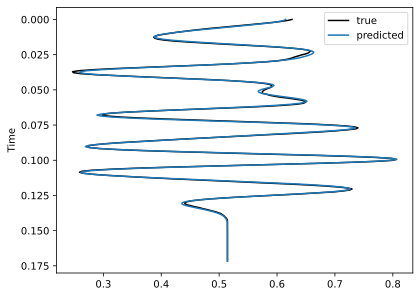

In [44]:
# sample_number = 400
sample_number = np.random.choice(phi_testset_true.shape[0], size = 1)[0]

plt.plot(np.squeeze(X_train_final[sample_number,:,:]), time_upscaled, color = "black", label='true');
plt.plot(seis_output_trainset[sample_number,:], time_upscaled, label='predicted');
plt.gca().invert_yaxis();
plt.legend();
plt.ylabel('Time');
sample_number

188

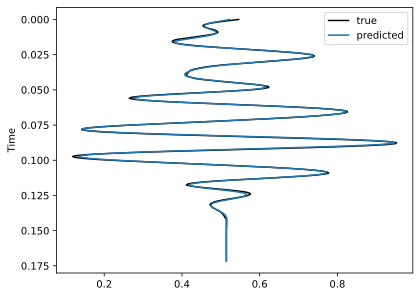

In [45]:
# sample_number = 400
sample_number = np.random.choice(phi_testset_true.shape[0], size = 1)[0]

plt.plot(np.squeeze(X_test_final[sample_number,:,:]), time_upscaled, color = "black", label='true');
plt.plot(seis_output_testset[sample_number,:], time_upscaled, label='predicted');
plt.gca().invert_yaxis();
plt.legend();
plt.ylabel('Time');
sample_number

## final

In [46]:
encoder_output_set = rw_pinn_encoder.predict(np.expand_dims(np.expand_dims(seis_normalized, axis=1),axis=3))
phi_set_pred = ((encoder_output_set+1)/2) * (phi_max - phi_min) + phi_min

decoder_output_set = rw_pinn.predict(np.expand_dims(np.expand_dims(seis_normalized, axis=1),axis=3))
seis_output_set=decoder_output_set[:,0:246]

In [47]:
phi_error = np.sqrt(mean_squared_error(phi_true, phi_set_pred))
print('Porosity RMS error:', phi_error)

Porosity RMS error: 0.07316921437693175


In [48]:
phi_train_error = np.sqrt(mean_squared_error(phi_trainset_true, phi_trainset_pred))
phi_test_error = np.sqrt(mean_squared_error(phi_testset_true, phi_testset_pred))

print('Porosity Trainset RMS error:', phi_train_error)
print('Porosity Testset RMS error:', phi_test_error)

Porosity Trainset RMS error: 0.0731714690854995
Porosity Testset RMS error: 0.07316019481466073


In [49]:
seis_error = np.sqrt(mean_squared_error(seis, seis_output_set*(np.max(seis)-np.min(seis))+ np.min(seis)))
seis_error_train = np.sqrt(mean_squared_error(np.squeeze(X_train_final)*(np.max(seis)-np.min(seis))+ np.min(seis), seis_output_trainset*(np.max(seis)-np.min(seis))+ np.min(seis)))
seis_error_test = np.sqrt(mean_squared_error(np.squeeze(X_test_final)*(np.max(seis)-np.min(seis))+ np.min(seis), seis_output_testset*(np.max(seis)-np.min(seis))+ np.min(seis)))

print('Seismic RMS error:', seis_error)
print('Seismic Train RMS error:', seis_error_train)
print('Seismic Test RMS error:', seis_error_test)

Seismic RMS error: 0.003983986045887863
Seismic Train RMS error: 0.0038460124392300844
Seismic Test RMS error: 0.004493715386112901


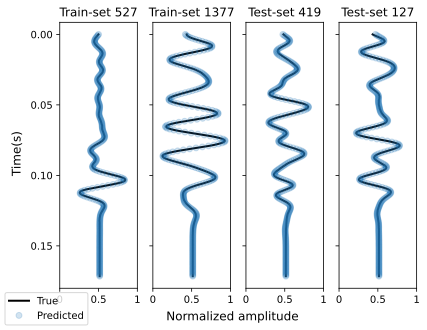

In [50]:
fig, axs = plt.subplots(1, 4, sharey=True)

i = np.random.choice(X_train_final.shape[0], size = 1)[0]
# axs[0].plot(np.squeeze(X_train_final[34,:,:]),time_upscaled,'k',linewidth=2,label='True');
# axs[0].plot(seis_output_trainset[34,:],time_upscaled,'o',alpha=0.2,label='Predicted');
axs[0].plot(np.squeeze(X_train_final[i,:,:]),time_upscaled,'k',linewidth=2,label='True');
axs[0].plot(seis_output_trainset[i,:],time_upscaled,'o',alpha=0.2,label='Predicted');
axs[0].set_yticks([0,0.05,0.1,0.15]);
axs[0].set_xticks([0,0.5,1]);
axs[0].set_xticklabels(('0','0.5','1'));
axs[0].set_title('Train-set {}'.format(i));

i = np.random.choice(X_train_final.shape[0], size = 1)[0]
# axs[1].plot(np.squeeze(X_train_final[64,:,:]),time_upscaled,'k',linewidth=2);
# axs[1].plot(seis_output_trainset[64,:],time_upscaled,'o',alpha=0.2);
axs[1].plot(np.squeeze(X_train_final[i,:,:]),time_upscaled,'k',linewidth=2);
axs[1].plot(seis_output_trainset[i,:],time_upscaled,'o',alpha=0.2);
axs[1].set_xticks([0,0.5,1]);
axs[1].set_xticklabels(('0','0.5','1'));
axs[1].set_title('Train-set {}'.format(i));

j = np.random.choice(X_test_final.shape[0], size = 1)[0]
# axs[2].plot(np.squeeze(X_test_final[21,:,:]),time_upscaled,'k',linewidth=2);
# axs[2].plot(seis_output_testset[21,:],time_upscaled,'o',alpha=0.2);
axs[2].plot(np.squeeze(X_test_final[21,:,:]),time_upscaled,'k',linewidth=2);
axs[2].plot(seis_output_testset[21,:],time_upscaled,'o',alpha=0.2);
axs[2].set_xticks([0,0.5,1]);
axs[2].set_xticklabels(('0','0.5','1'));
axs[2].set_title('Test-set {}'.format(j));

j = np.random.choice(X_test_final.shape[0], size = 1)[0]
# axs[3].plot(np.squeeze(X_test_final[26,:,:]),time_upscaled,'k',linewidth=2);
# axs[3].plot(seis_output_testset[26,:],time_upscaled,'o',alpha=0.2);
axs[3].plot(np.squeeze(X_test_final[j,:,:]),time_upscaled,'k',linewidth=2);
axs[3].plot(seis_output_testset[j,:],time_upscaled,'o',alpha=0.2);
axs[3].set_xticks([0,0.5,1]);
axs[3].set_xticklabels(('0','0.5','1'));
axs[3].set_title('Test-set {}'.format(j));

fig.supxlabel('Normalized amplitude');
fig.supylabel('Time(s)');
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left');

plt.gca().invert_yaxis();

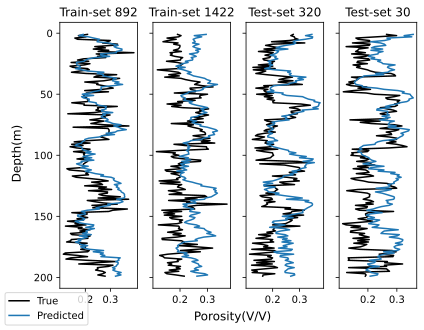

In [51]:
fig, axs = plt.subplots(1, 4, sharey=True);

i = np.random.choice(phi_trainset_true.shape[0], size = 1)[0]
# axs[0].plot(phi_trainset_true[34, :], depth,'k',label='True');
# axs[0].plot(phi_trainset_pred[34, :], depth,label='Predicted');
axs[0].plot(phi_trainset_true[i, :], depth,'k',label='True');
axs[0].plot(phi_trainset_pred[i, :], depth,label='Predicted');
axs[0].set_yticks([0,50,100,150,200]);
axs[0].set_xticks([0.2,0.3]);
axs[0].set_title('Train-set {}'.format(i));

i = np.random.choice(phi_trainset_true.shape[0], size = 1)[0]
# axs[1].plot(phi_trainset_true[64, :], depth,'k');
# axs[1].plot(phi_trainset_pred[64, :], depth);
axs[1].plot(phi_trainset_true[i, :], depth,'k');
axs[1].plot(phi_trainset_pred[i, :], depth);
axs[1].set_xticks([0.2,0.3]);
axs[1].set_title('Train-set {}'.format(i));

j = np.random.choice(phi_testset_true.shape[0], size = 1)[0]
# axs[2].plot(phi_testset_true[21, :], depth,'k');
# axs[2].plot(phi_testset_pred[21, :], depth);
axs[2].plot(phi_testset_true[j, :], depth,'k');
axs[2].plot(phi_testset_pred[j, :], depth);
axs[2].set_xticks([0.2,0.3]);
axs[2].set_title('Test-set {}'.format(j));

j = np.random.choice(phi_testset_true.shape[0], size = 1)[0]
# axs[3].plot(phi_testset_true[26, :], depth,'k');
# axs[3].plot(phi_testset_pred[26, :], depth);
axs[3].plot(phi_testset_true[j, :], depth,'k');
axs[3].plot(phi_testset_pred[j, :], depth);
axs[3].set_xticks([0.2,0.3]);
axs[3].set_title('Test-set {}'.format(j));

fig.supxlabel('Porosity(V/V)');
fig.supylabel('Depth(m)');
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left');

plt.gca().invert_yaxis();